In [4]:
from turning_scene import *
from l5kit.rasterization.rasterizer_builder import _load_metadata

In [5]:
# set env variable for data
os.environ["L5KIT_DATA_FOLDER"] = "C:\\Users\\zheng\\Desktop\\UMich\\Independent Study\\prediction-dataset"
# get config
cfg = load_config_data("C:\\Users\\zheng\\Desktop\\UMich\\Independent Study\\Codes\\python codes\\visualisation_config.yaml")
print(cfg)

dm = LocalDataManager()
dataset_path = dm.require(cfg["val_data_loader"]["key"])
zarr_dataset = ChunkedDataset(dataset_path)
zarr_dataset.open()
print(zarr_dataset)

rast = build_rasterizer(cfg, dm)
ego_dataset = EgoDataset(cfg, zarr_dataset, rast)
# agent_dataset = AgentDataset(cfg, zarr_dataset, rast)
# Obatin the information from semantic map

semantic_map_filepath = dm.require(cfg["raster_params"]["semantic_map_key"])
dataset_meta = _load_metadata(cfg["raster_params"]["dataset_meta_key"], dm)
world_to_ecef = np.array(dataset_meta["world_to_ecef"], dtype=np.float64)
Map_Api = MapAPI(semantic_map_filepath, world_to_ecef)

{'format_version': 4, 'model_params': {'model_architecture': 'resnet50', 'history_num_frames': 0, 'future_num_frames': 50, 'step_time': 0.1}, 'raster_params': {'raster_size': [320, 320], 'pixel_size': [0.5, 0.5], 'ego_center': [0.6, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.5, 'disable_traffic_light_faces': False, 'set_origin_to_bottom': True}, 'val_data_loader': {'key': 'scenes/train.zarr', 'batch_size': 12, 'shuffle': False, 'num_workers': 16}}
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+------

In [6]:
class Trajectory(Scene):
    
    def __init__(self, dataset, Map_Api):
        super(Trajectory, self).__init__(dataset, Map_Api)


In [7]:
Test = Trajectory(zarr_dataset, Map_Api)

In [9]:
Test.generate_info_from_MAP()
Test.turning_scenes_finding()

Filtering the turning scenes: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16265/16265 [00:33<00:00, 483.63it/s]


# Find the scene index which are at the intersection: 'sGK1'

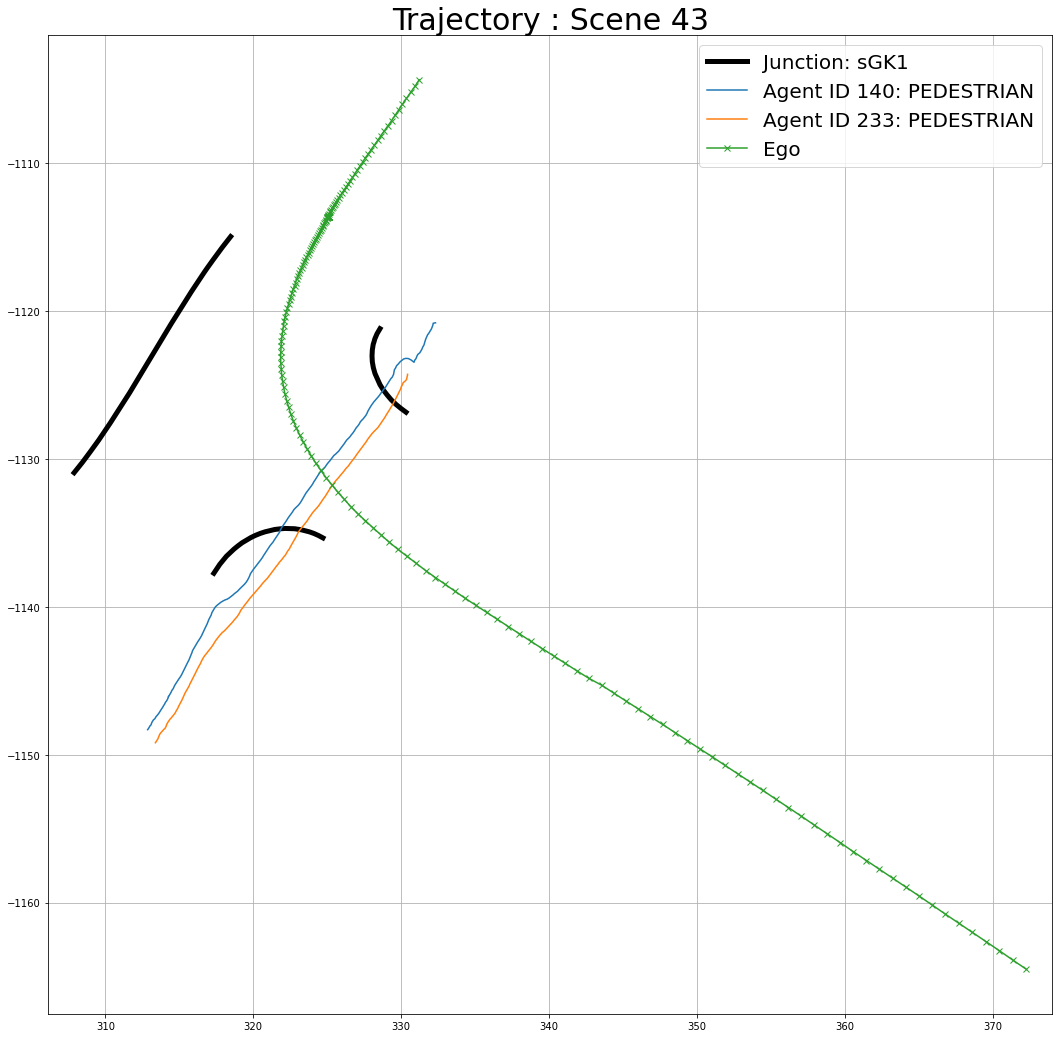

In [120]:
# train_junction_scene['sGK1'] = list_idx
# np.save('train_junction_scene.npy', train_junction_scene)

scene = 43
        
plt.figure(figsize=(18,18))


lane_list = ['F/RY','AcOB','N3wG']


plt.plot(Test.map_api.get_lane_coords(lane_list[0])['xyz_right'][:,0], Test.map_api.get_lane_coords(lane_list[0])['xyz_right'][:,1],
             label='Junction: '+'sGK1', color='k',linewidth=5)
for lane in lane_list[1:]:
#     plt.plot(Test.map_api.get_lane_coords(lane)['xyz_left'][:,0], Test.map_api.get_lane_coords(lane)['xyz_left'][:,1], color='k')
    plt.plot(Test.map_api.get_lane_coords(lane)['xyz_right'][:,0], Test.map_api.get_lane_coords(lane)['xyz_right'][:,1],
             color='k',linewidth=5)
 


frame_interval = zarr_dataset.scenes[scene]['frame_index_interval']
agent_interval_begin = zarr_dataset.frames[frame_interval[0]]['agent_index_interval'][0]
agent_interval_end = zarr_dataset.frames[frame_interval[1]-1]['agent_index_interval'][1]
agent_id = zarr_dataset.agents[agent_interval_begin:agent_interval_end]['track_id']
agent_label_prob = zarr_dataset.agents[agent_interval_begin:agent_interval_end]['label_probabilities']
agent_centroid = zarr_dataset.agents[agent_interval_begin:agent_interval_end]['centroid']
    
for agent in [12, 13, 130, 140, 233, 586, 649, 743]:
    agent_loc = agent_centroid[np.where(agent_id==agent)[0]]
    if agent_loc.shape[0] > 30:
        plt.plot(agent_loc[:,0],agent_loc[:,1],label='Agent ID '+str(agent)+': '+'PEDESTRIAN')

ego_translation = zarr_dataset.frames[frame_interval[0]:frame_interval[1]]['ego_translation']
plt.plot(ego_translation[:,0],ego_translation[:,1],label='Ego',marker='x')

plt.axis("equal")
plt.grid(which='both')
plt.legend(fontsize=20)
plt.title('Trajectory : Scene '+str(scene), fontsize=30)
axes = plt.gca()



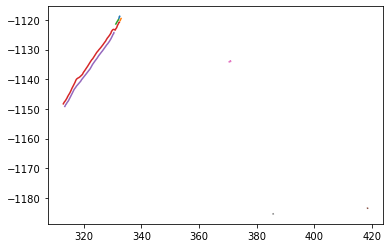

In [96]:
for agent in [12, 13, 130, 140, 233, 586, 649, 743]:
    agent_loc = agent_centroid[np.where(agent_id==agent)[0]]
    plt.plot(agent_loc[:,0],agent_loc[:,1],label='Agent '+str(agent))

In [84]:
agent_centroid[np.where(agent_id==12)[0]]

array([], shape=(0, 2), dtype=float64)

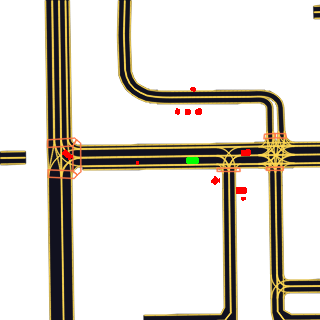

In [98]:
Test.scene_visualize(43,ego_dataset,cfg)

In [44]:
scene_pedestrian = []

for scene in train_junction_scene['sGK1']:
    frame_interval = zarr_dataset.scenes[scene]['frame_index_interval']
    agent_interval_begin = zarr_dataset.frames[frame_interval[0]]['agent_index_interval'][0]
    agent_interval_end = zarr_dataset.frames[frame_interval[1]-1]['agent_index_interval'][1]
    agent_label_prob = zarr_dataset.agents[agent_interval_begin:agent_interval_end]['label_probabilities']
    
    if 

[8,
 43,
 57,
 77,
 93,
 142,
 218,
 233,
 264,
 309,
 317,
 339,
 357,
 393,
 434,
 482,
 517,
 595,
 599,
 636,
 706,
 752,
 763,
 805,
 820,
 859,
 933,
 967,
 987,
 1030,
 1048,
 1086,
 1134,
 1176,
 1196,
 1228,
 1286,
 1312,
 1407,
 1435,
 1505,
 1517,
 1563,
 1579,
 1652,
 1663,
 1720,
 1766,
 1805,
 1819,
 1856,
 1869,
 1875,
 1886,
 1966,
 2033,
 2039,
 2094,
 2138,
 2163,
 2200,
 2221,
 2261,
 2286,
 2330,
 2394,
 2436,
 2483,
 2497,
 2524,
 2541,
 2573,
 2591,
 2615,
 2631,
 2681,
 2719,
 2738,
 2784,
 2846,
 2889,
 2900,
 2942,
 2958,
 3020,
 3056,
 3123,
 3184,
 3204,
 3251,
 3266,
 3305,
 3361,
 3376,
 3442,
 3463,
 3477,
 3528,
 3619,
 3648,
 3667,
 3725,
 3781,
 3823,
 3864,
 3881,
 3926,
 3944,
 3984,
 4003,
 4045,
 4060,
 4115,
 4181,
 4201,
 4253,
 4297,
 4330,
 4347,
 4401,
 4467,
 4482,
 4524,
 4538,
 4589,
 4666,
 4729,
 4817,
 4830,
 4925,
 4981,
 5090,
 5146,
 5199,
 5296,
 5315,
 5415,
 5539,
 5576,
 5589,
 5620,
 5634,
 5672,
 5728,
 5790,
 5811,
 5837,
 5966,

In [106]:
frame_interval = zarr_dataset.scenes[43]['frame_index_interval']
agent_interval_begin = zarr_dataset.frames[frame_interval[0]]['agent_index_interval'][0]
agent_interval_end = zarr_dataset.frames[frame_interval[1]-1]['agent_index_interval'][1]
agent_id = zarr_dataset.agents[agent_interval_begin:agent_interval_end]['track_id']
agent_label_prob = zarr_dataset.agents[agent_interval_begin:agent_interval_end]['label_probabilities']
agent_centroid = zarr_dataset.agents[agent_interval_begin:agent_interval_end]['centroid']



label = ['Car','Van','Tram','Bus','Truck','EV','OV','Pedestrian','Bicycle','Motorcycle','Cyclist','Motorcyclist']
label_idx = list(range(3,15))



# find the agents whose label is PEDESTRIAN
valid_Pedestrian_idx = np.where(agent_label_prob[:,14]>0.5)[0]
valid_Car_idx = np.where(agent_label_prob[:,3]>0.5)[0]
valid_Van_idx = np.where(agent_label_prob[:,4]>0.5)[0]
valid_Tram_idx = np.where(agent_label_prob[:,5]>0.5)[0]
valid_Bus_idx = np.where(agent_label_prob[:,6]>0.5)[0]
valid_Truck_idx = np.where(agent_label_prob[:,7]>0.5)[0]
valid_EV_idx = np.where(agent_label_prob[:,8]>0.5)[0]
valid_OV_idx = np.where(agent_label_prob[:,9]>0.5)[0]


valid_Pedestrian_id = set(agent_id[valid_Pedestrian_idx])
valid_Pedestrian_id = set(agent_id[valid_Pedestrian_idx])
valid_Pedestrian_id = set(agent_id[valid_Pedestrian_idx])
valid_Pedestrian_id = set(agent_id[valid_Pedestrian_idx])
valid_Pedestrian_id = set(agent_id[valid_Pedestrian_idx])
valid_Pedestrian_id = set(agent_id[valid_Pedestrian_idx])
valid_Pedestrian_id = set(agent_id[valid_Pedestrian_idx])
valid_Pedestrian_id = set(agent_id[valid_Pedestrian_idx])

    

In [107]:
list(range(3,15))

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [80]:
set(agent_id[np.where(agent_label_prob[:,14]>0.5)[0]])

{12, 13, 130, 140, 233, 586, 649, 743}

In [85]:
np.where(agent_id==12)[0]

array([], dtype=int64)

In [91]:
agent_id

743

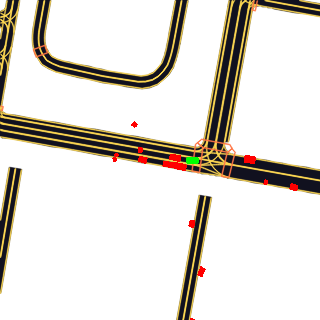

In [34]:
indexes = Test.scene_turning_frames(125)
images = []

for idx in indexes:

    data = ego_dataset[idx]
    im = data["image"].transpose(1, 2, 0)
    im = ego_dataset.rasterizer.to_rgb(im)
    target_positions_pixels = transform_points(data["target_positions"], data["raster_from_agent"])
    center_in_pixels = np.asarray(cfg["raster_params"]["ego_center"]) * cfg["raster_params"]["raster_size"]
#     draw_trajectory(im, target_positions_pixels, TARGET_POINTS_COLOR, yaws=data["target_yaws"])
    clear_output(wait=True)
    display(PIL.Image.fromarray(im))

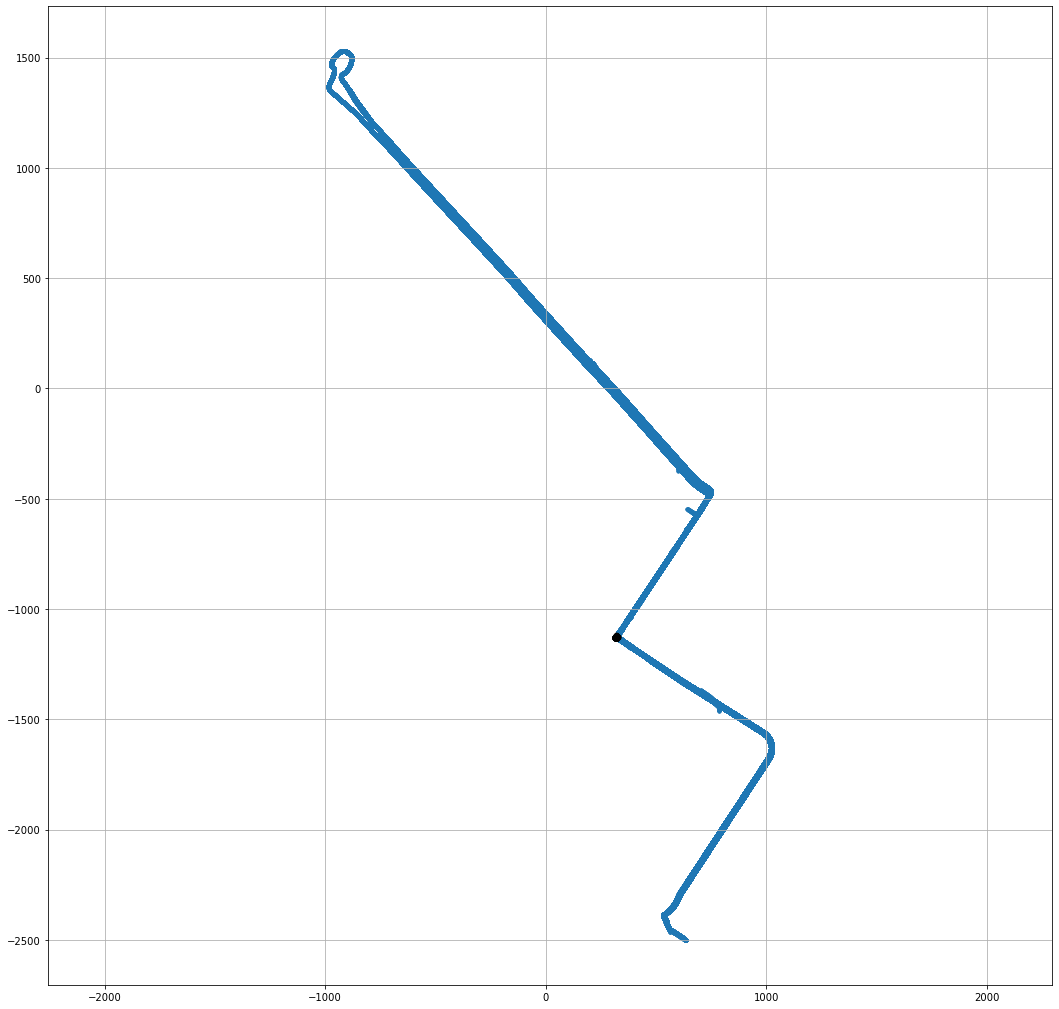

In [35]:
Test.junction_visualize('sGK1')